In [128]:
import pyart
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import products
import sort_radar
from time import process_time

### EVALUATING SINGLE-POL PRODUCTS

Let's read the radar volume

In [96]:
radar = pyart.aux_io.read_gamic('217BRS-20221030173104.HDF5')

Sort rays and perform the interpolation between rays and for all sweeps. This is only necessary if the number of rays between sweep is not constant as is the case of the Chapecó radar

In [56]:
radar = sort_radar.main(radar)

Evaluate the VIL, ET, VILD and Waldvogel. These variables will be directly added to the radar object. The 0 °C isotherm height needed for evaluating Waldvogel is of approximately 4000 m.

Note: VIL may be a little slow in this case and the integration may take around 20 seconds. 

In [20]:
start_time = process_time()

radar = products.calc_VIL(radar, 'corrected_reflectivity')
radar = products.calc_ET(radar, 'corrected_reflectivity')
radar = products.calc_VILD(radar, 'VIL', 'ET')
radar = products.calc_WV(radar, h0c=4000.0)

print("--- %s seconds ---" % (process_time() - start_time))

--- 29.052008700000002 seconds ---


Plot the results

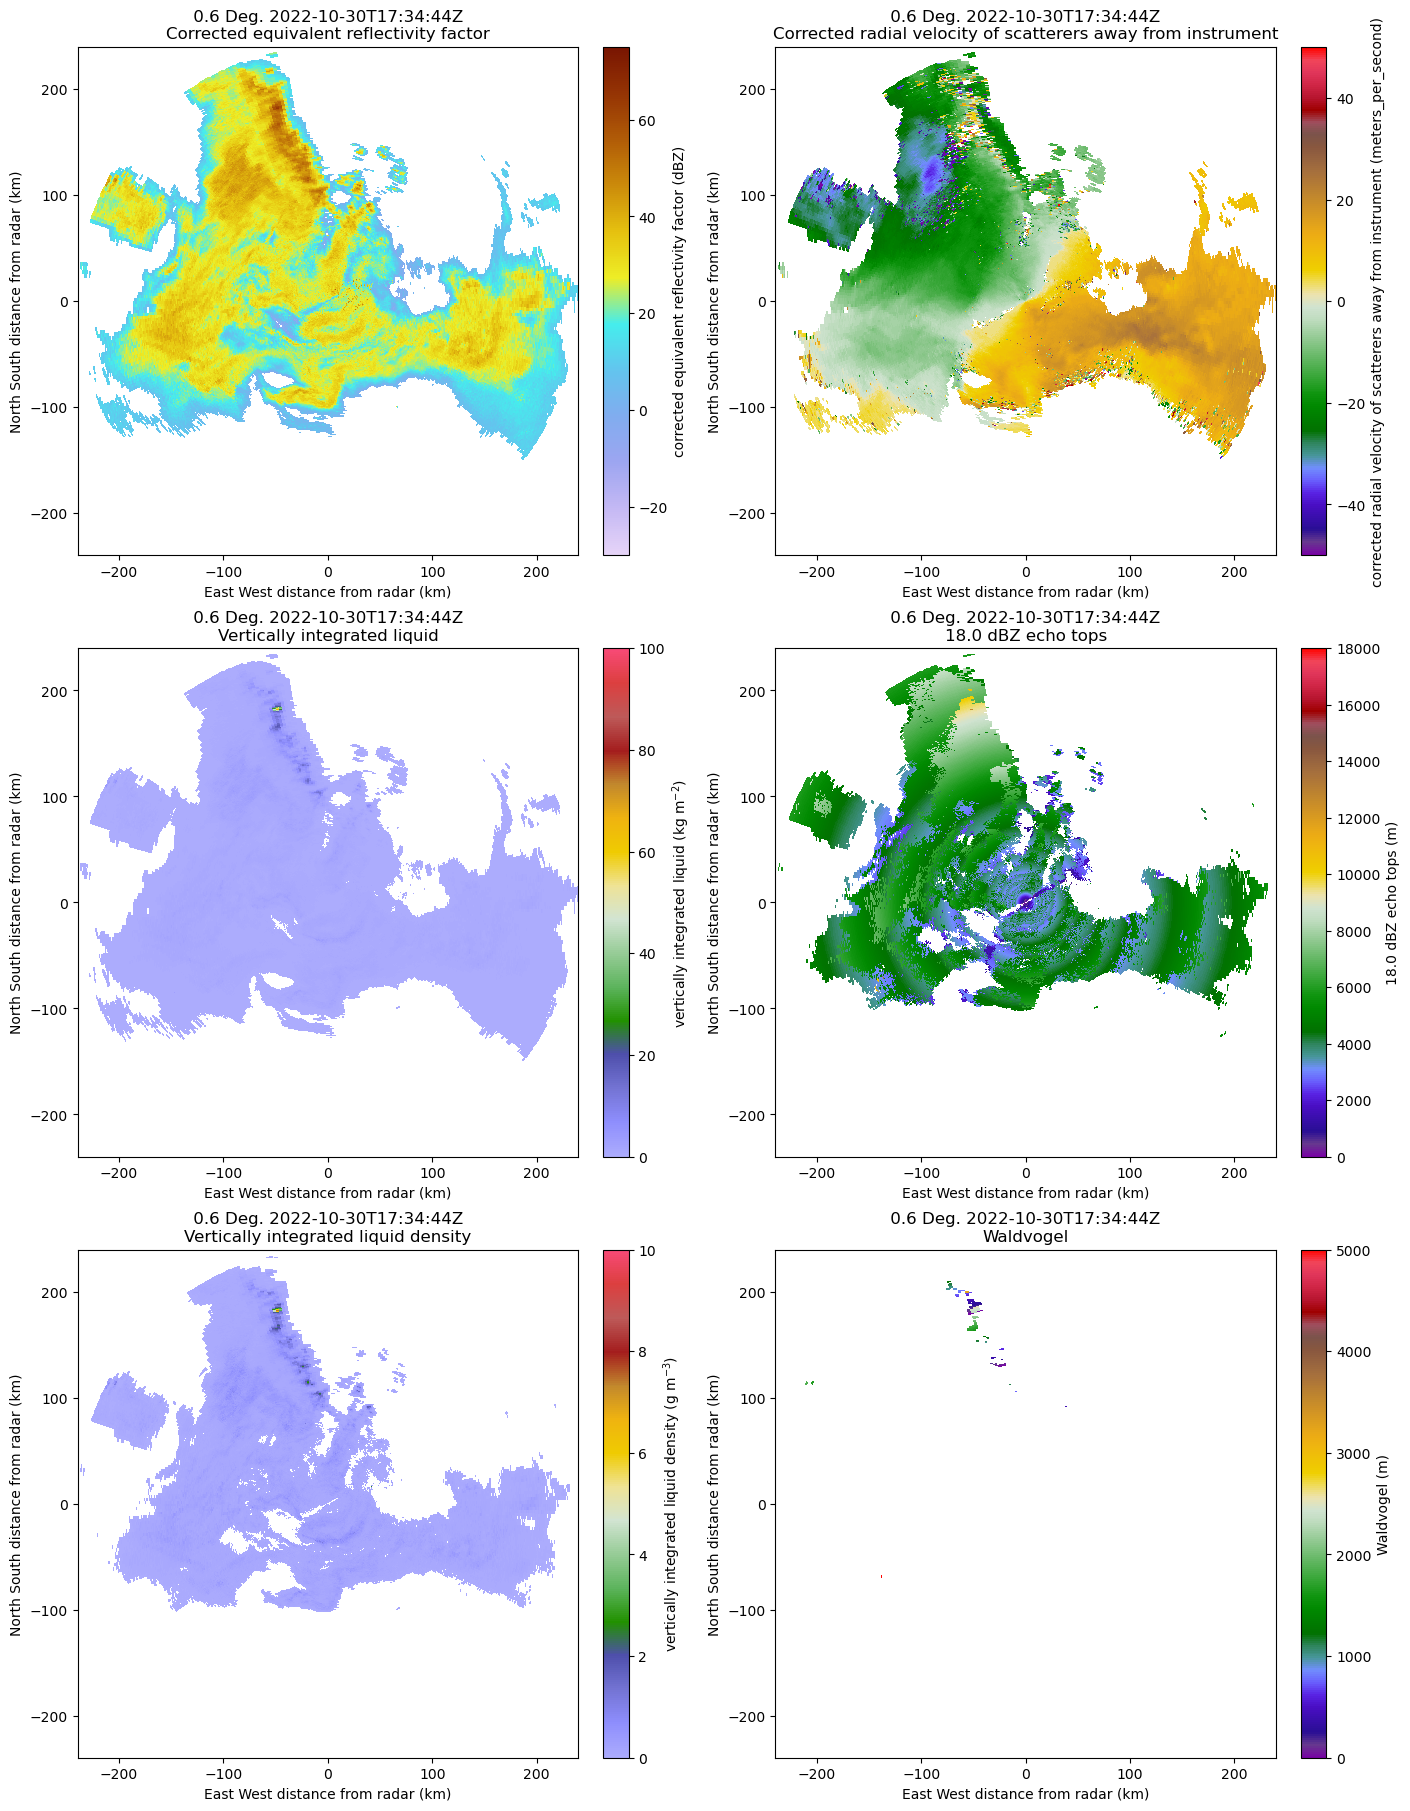

In [21]:
display = pyart.graph.RadarDisplay(radar)

fig, axs = plt.subplots(3, 2, figsize = [14, 18], constrained_layout = True)
display.plot_ppi('corrected_reflectivity', 0, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('VIL', 0, vmin = 0, vmax=100, cmap = pyart.graph.cm.Theodore16, ax = axs.ravel()[2])
display.plot_ppi('ET', 0, vmin = 0, vmax=18000, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[3],)
display.plot_ppi('VILD', 0, vmin = 0, vmax = 10, cmap = pyart.graph.cm.Theodore16, ax = axs.ravel()[4])
display.plot_ppi('Waldvogel', 0, vmin = 0, vmax = 5000, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[5])

#plt.savefig('/mnt/c/Users/User/Desktop/aa.jpg', dpi = 300, bbox_inches = 'tight')